In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, GroupKFold, RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from hyperopt import hp
import random
from sklearn.ensemble import RandomForestClassifier
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
tabular= pd.read_csv('/Users/finnschonknecht/Desktop/XGB_train_folder/tabular.csv')
targets = pd.read_csv('/Users/finnschonknecht/Desktop/XGB_train_folder/binary_personalised_targets.csv')
personality_df = pd.read_csv('/Users/finnschonknecht/Desktop/XGB_train_folder/personality_df.csv')

In [3]:
personality_columns = ['Openness', 'Agreeableness', 'Conscientiousness', 'Extraversion', 'Neuroticism']

In [4]:
personality_flags = ['Openness_High', 'Agreeableness_High', 'Conscientiousness_High', 'Extraversion_High', 'Neuroticism_High']

In [5]:
tabular.fillna(0, inplace=True)

In [6]:
unique_ids = tabular['Pcode'].unique()
random.seed(149)   
test_ids = np.random.choice(unique_ids, 15, replace=False)

In [7]:
test_data= tabular[tabular['Pcode'].isin(test_ids)]
train_data= tabular[~tabular['Pcode'].isin(test_ids)]

In [8]:
def encode_dataframe(df):
    # Encode the Gender column
    if 'Gender' in df.columns:
        le = LabelEncoder()
        df['Gender'] = le.fit_transform(df['Gender'])

    # Convert object columns to category if needed
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].astype('category')
    
    return df

def scale_numeric_columns(df_train, df_test, exclude_columns):
    # Identify numeric columns
    numeric_cols = df_train.select_dtypes(include=['float64', 'int64']).columns

    # Exclude specified columns from numeric columns
    numeric_cols = [col for col in numeric_cols if col not in exclude_columns]

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform the training data
    df_train_scaled = df_train.copy()
    df_train_scaled[numeric_cols] = scaler.fit_transform(df_train[numeric_cols])

    # Transform the test data using the same scaler
    df_test_scaled = df_test.copy()
    df_test_scaled[numeric_cols] = scaler.transform(df_test[numeric_cols])

    return df_train_scaled, df_test_scaled

def create_personality_flags(df, personality_columns):
    for col in personality_columns:
        df[f'{col}_High'] = (df[col] >= 9).astype(int)
    return df

In [9]:
train_data, test_data = scale_numeric_columns(
    train_data, test_data, ['Stress_binary', 'Valence_binary', 'Arousal_binary', 'day_0', 'day_1', 'day_2', 'day_3', 
                            'day_4', 'day_5', 'day_6', 'Neuroticism', 'Openness', 'Agreeableness', 
                            'Conscientiousness', 'Extraversion'])

In [10]:
def RandomForestGroupKFoldCV(data, train, test, unique_ids, test_ids, idcolumn, outcomevar, personality_columns, personality_flags, dropcols=[], n_splits=5):
    
    # Assuming encode_dataframe and create_personality_flags functions are defined
  
    train_data = encode_dataframe(train.copy())
    test_data = encode_dataframe(test.copy())
    
    train_data = create_personality_flags(train_data, personality_columns)
    test_data = create_personality_flags(test_data, personality_columns)
    
    best_hyperparams = []
    F1 = []
    feature_importances_list = []
    shap_values_list = []

    group_kfold = GroupKFold(n_splits=n_splits)

    param_dist = {
        'n_estimators': [100, 200, 300, 500, 1000, 1500],
        'max_depth': [5, 10, 15, 30, 50],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1,2,4,10],
        'bootstrap': [True, False]
    }

    # Store metrics for each personality trait
    trait_metrics_cv = {trait: {'precision': [], 'recall': [], 'f1': []} for trait in personality_flags}
    trait_metrics_train_cv = {trait: {'precision': [], 'recall': [], 'f1': []} for trait in personality_flags}

    # Perform GroupKFold on the remaining data
    for train_index, val_index in group_kfold.split(train_data, groups=train_data[idcolumn]):
        data_train = train_data.iloc[train_index]
        data_val = train_data.iloc[val_index]

        rf = RandomForestClassifier(random_state=0, n_jobs=-1)
        random_search = GridSearchCV(rf, cv=3, scoring='f1_macro', n_jobs=-1, param_grid=param_dist)
        random_search.fit(data_train.drop(columns=dropcols + [outcomevar]), data_train[outcomevar])

        best_params = random_search.best_params_
        best_hyperparams.append(best_params)

        rf_best = RandomForestClassifier(**best_params, random_state=0, n_jobs=-1)
        rf_best.fit(data_train.drop(columns=dropcols + [outcomevar]), data_train[outcomevar])

        val_predictions = rf_best.predict(data_val.drop(columns=dropcols + [outcomevar]))
        train_predictions = rf_best.predict(data_train.drop(columns=dropcols + [outcomevar]))
        F1.append(f1_score(data_val[outcomevar], val_predictions, average='macro'))

        #Calculate metrics for each personality trait on validation set
        for trait in personality_flags:
            val_pred_binary = (val_predictions == 1).astype(int)
            precision_val = precision_score(data_val[trait], val_pred_binary)
            recall_val = recall_score(data_val[trait], val_pred_binary)
            f1_val = f1_score(data_val[trait], val_pred_binary)
            trait_metrics_cv[trait]['precision'].append(precision_val)
            trait_metrics_cv[trait]['recall'].append(recall_val)
            trait_metrics_cv[trait]['f1'].append(f1_val)
            
            train_pred_binary = (train_predictions == 1).astype(int)
            precision_train = precision_score(data_train[trait], train_pred_binary)
            recall_train = recall_score(data_train[trait], train_pred_binary)
            f1_train = f1_score(data_train[trait], train_pred_binary)
            trait_metrics_train_cv[trait]['precision'].append(precision_train)
            trait_metrics_train_cv[trait]['recall'].append(recall_train)
            trait_metrics_train_cv[trait]['f1'].append(f1_train)


        # Compute SHAP values for the validation set
        #explainer = shap.TreeExplainer(rf_best)
        #shap_values = explainer.shap_values(data_val.drop(columns=dropcols + [outcomevar]))
        #shap_values_list.append(shap_values)
        
        print('...Fold processing complete.')

    mean_F1_micro = np.mean(F1)
    std_F1_micro = np.std(F1)

    # Compute the most common bootstrap value
    bootstrap_values = [d['bootstrap'] for d in best_hyperparams]
    most_common_bootstrap = max(set(bootstrap_values), key=bootstrap_values.count)

    # Calculate average values for other hyperparameters
    int_params = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']
    best_params_avg = {param: int(np.mean([d[param] for d in best_hyperparams])) for param in int_params}
    best_params_avg['bootstrap'] = most_common_bootstrap

    final_model = RandomForestClassifier(**best_params_avg, random_state=0, n_jobs=-1)
    final_model.fit(train_data.drop(columns=dropcols + [outcomevar]), train_data[outcomevar])

    # Predict on the separate test set
    test_predictions = final_model.predict(test_data.drop(columns=dropcols + [outcomevar]))
    test_F1_score = f1_score(test_data[outcomevar], test_predictions, average='macro')
    test_confusion_matrix = confusion_matrix(test_data[outcomevar], test_predictions)
    
    test_trait_metrics = {trait: {} for trait in personality_flags}
    test_pred_binary = (test_predictions == 1).astype(int)
    for trait in personality_flags:
        precision = precision_score(test_data[trait], test_pred_binary)
        recall = recall_score(test_data[trait], test_pred_binary)
        f1 = f1_score(test_data[trait], test_pred_binary)
        test_trait_metrics[trait]['precision'] = precision
        test_trait_metrics[trait]['recall'] = recall
        test_trait_metrics[trait]['f1'] = f1
    

    #explainer_final = shap.TreeExplainer(final_model, test_data.drop(columns=dropcols + [outcomevar]), feature_perturbation="interventional")
    #shap_values_final = explainer_final.shap_values(test_data.drop(columns=dropcols + [outcomevar]), check_additivity=False)    
    
    print(f'Mean F1 (Overall): {mean_F1_micro}')
    print(f'Std F1 (Overall): {std_F1_micro}')
    print(f'Test F1 Score: {test_F1_score}')

    print('Overall Confusion Matrix:')
    print(test_confusion_matrix)
    report = classification_report(test_data[outcomevar], test_predictions)
    print(report)
    
    return mean_F1_micro, std_F1_micro, test_F1_score, test_confusion_matrix, best_params_avg, final_model, test_predictions

In [11]:
mean_F1_micro, std_F1_micro, test_F1_score, test_confusion_matrix, best_params_avg, final_model, test_predictions  = RandomForestGroupKFoldCV(
    data=tabular,
    train=train_data,
    test=test_data,
    unique_ids=unique_ids,
    test_ids=test_ids,
    idcolumn='Pcode',
    outcomevar='Stress_binary',
    personality_columns=personality_columns,
    personality_flags = personality_flags,
    dropcols=['Pcode', 'ResponseTime', 'Arousal_binary', 'Valence_binary'],
    n_splits=5
)

...Fold processing complete.
...Fold processing complete.
...Fold processing complete.
...Fold processing complete.
...Fold processing complete.
Mean F1 (Overall): 0.5152957738013886
Std F1 (Overall): 0.011061416200070751
Test F1 Score: 0.5426530066815145
Overall Confusion Matrix:
[[386 205]
 [273 210]]
              precision    recall  f1-score   support

         0.0       0.59      0.65      0.62       591
         1.0       0.51      0.43      0.47       483

    accuracy                           0.55      1074
   macro avg       0.55      0.54      0.54      1074
weighted avg       0.55      0.55      0.55      1074



No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


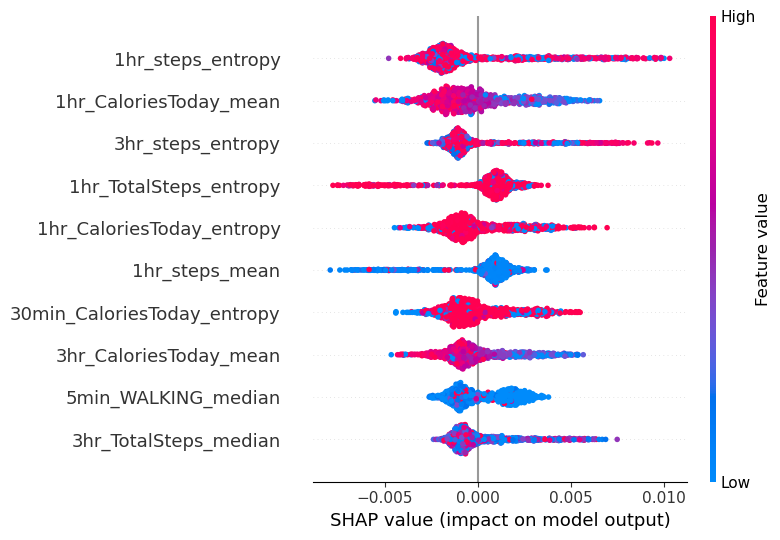

In [12]:
shap_values_final_stress = shap_values_stress[1]
shap.summary_plot(shap_values_final_stress, test_data, max_display=10)

In [11]:
mean_F1_micro_valence, std_F1_micro_valence, test_F1_score_valence, test_confusion_matrix_valence, best_params_avg_valence, final_model_valence, test_predictions_valence = RandomForestGroupKFoldCV(
    data=tabular,
    train=train_data,
    test=test_data,
    unique_ids=unique_ids,
    test_ids=test_ids,
    idcolumn='Pcode',
    outcomevar='Valence_binary',
    personality_columns=personality_columns,
    personality_flags= personality_flags,
    dropcols=['Pcode', 'ResponseTime', 'Arousal_binary', 'Stress_binary'],
    n_splits=5
)

...Fold processing complete.
...Fold processing complete.
...Fold processing complete.
...Fold processing complete.
...Fold processing complete.
Mean F1 (Overall): 0.5238423685921909
Std F1 (Overall): 0.01380002715416123
Test F1 Score: 0.5593864500125167
Overall Confusion Matrix:
[[140 262]
 [137 480]]
              precision    recall  f1-score   support

         0.0       0.51      0.35      0.41       402
         1.0       0.65      0.78      0.71       617

    accuracy                           0.61      1019
   macro avg       0.58      0.56      0.56      1019
weighted avg       0.59      0.61      0.59      1019



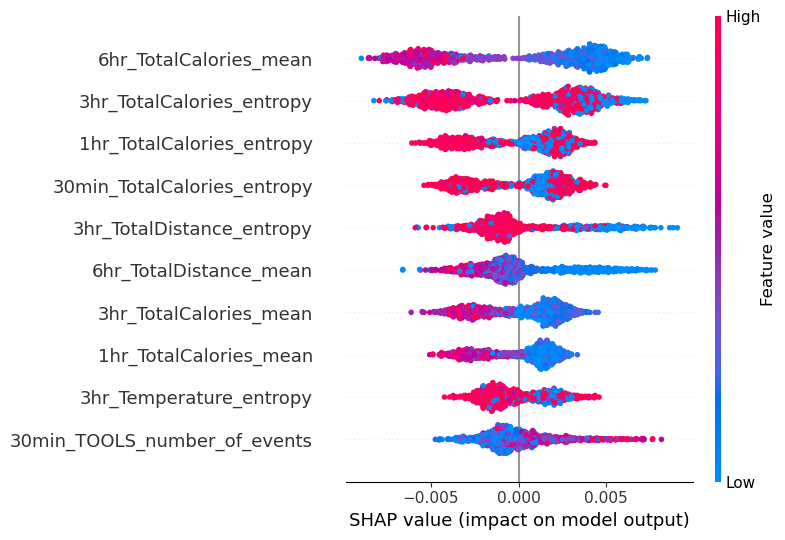

In [45]:
shap_values_final_class1 = shap_values_valence
shap.summary_plot(shap_values_valence[0], test_data, max_display=10)
plt.show()
plt.savefig('shap_beeswarm_plot_low_valence.png', bbox_inches='tight')
plt.close()

In [ ]:
shap.summary_plot(shap_values_final_class1[0], test_data, max_display=10)

In [12]:
mean_F1_micro_arousal, std_F1_micro_arousal, test_F1_score_arousal, test_confusion_matrix_arousal, best_params_avg_arousal, final_model_arousal, test_predictions_arousal = RandomForestGroupKFoldCV(
    data=tabular,
    train=train_data,
    test=test_data,
    unique_ids=unique_ids,
    test_ids=test_ids,
    idcolumn='Pcode',
    outcomevar='Arousal_binary',
    personality_columns=personality_columns,
    personality_flags= personality_flags,
    dropcols=['Pcode', 'ResponseTime', 'Valence_binary', 'Stress_binary'],
    n_splits=5
)

...Fold processing complete.
...Fold processing complete.
...Fold processing complete.
...Fold processing complete.
...Fold processing complete.
Mean F1 (Overall): 0.5805157919866556
Std F1 (Overall): 0.007774632379708246
Test F1 Score: 0.595066061405926
Overall Confusion Matrix:
[[336 205]
 [206 272]]
              precision    recall  f1-score   support

         0.0       0.62      0.62      0.62       541
         1.0       0.57      0.57      0.57       478

    accuracy                           0.60      1019
   macro avg       0.60      0.60      0.60      1019
weighted avg       0.60      0.60      0.60      1019



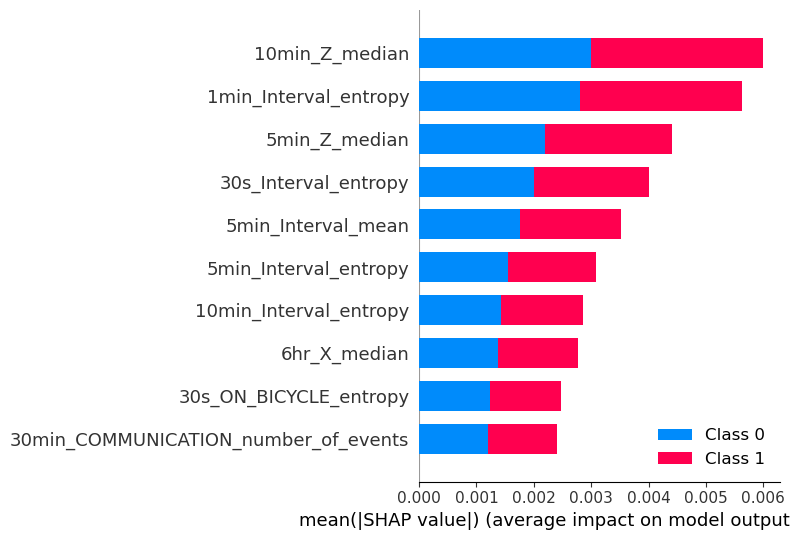

In [50]:
shap_values_final_arousal = shap_values_arousal
shap.summary_plot(shap_values_final_arousal, test_data, max_display=10)